# Project Notes and Explanation

## Overview of Model Selection and Training Process

Before stepping into training and building this model, I conducted a comprehensive comparison between two popular deep learning architectures for image classification—**ResNet** and **MobileNetV2**. Through extensive experimentation, research, and iterative discussions, I explored various data preparation techniques, augmentation strategies, and training methodologies to determine which approach would yield the best performance with optimal processing time.
> Data for this project was sourced from the Kaggle dataset [Garbage Classification](https://www.kaggle.com/datasets/mostafaabla/garbage-classification).

## Comparison and Findings
- **Initial Comparison:**  
  I began by training both ResNet and MobileNetV2 models using the same data preparation pipeline. I applied multiple data filtering and augmentation techniques, along with class balancing, to evaluate the performance of each model. 

- **Performance Evaluation:**  
  After evaluating both models, MobileNetV2 consistently demonstrated higher accuracy and efficiency. The model that performed best during this phase was saved as **Model_pro.h5** (MobileNetV2), providing a benchmark for further improvements.

- **Final Decision:**  
  Based on these findings, I decided to focus on MobileNetV2 for the final model. Its lightweight architecture and robust feature extraction proved to be the best choice for our waste classification task.

## Data Preparation Challenges and Solutions

One of the main challenges was handling the imbalanced dataset:

- **Imbalanced Dataset:**  
  Some classes (e.g., shoes and clothes) had a disproportionately high number of images compared to others.
  
- **Initial Approach:**  
  I first attempted to balance the dataset by augmenting underrepresented classes up to a target count. While this increased the number of samples, it also significantly increased processing time.
  
- **Refined Approach:**  
  Ultimately, I found that incorporating **class weighting** during training was a more efficient solution to mitigate class imbalance. By computing balanced class weights based on the training data distribution, the model is encouraged to pay more attention to underrepresented classes without excessively inflating the dataset size.

## Conclusion

This notebook reflects an iterative and data-driven approach:
- A thorough evaluation confirmed that MobileNetV2 was the best architecture for our waste classification task in terms of accuracy and processing time.
- The data preparation pipeline, which includes robust filtering (duplicate removal, quality filtering with blurriness, brightness, and edge density metrics), augmentation, and class balancing, set a strong foundation for model training.
- The final model was fine-tuned using a carefully designed training regimen that included early stopping and learning rate adjustments, ultimately yielding superior performance on unseen data.

The process showcased here not only validates my hypotheses and research findings but also demonstrates a practical strategy for attaining high performance with efficient processing time.

---



# Library Imports Documentaion

This cell imports all the necessary libraries for our waste classification project. The libraries are organized into functional groups as follows:

## Standard Libraries
- **os**: Provides functions for interacting with the operating system (file and directory operations).
- **time**: Used for tracking execution time and measuring performance of different code phases.
- **csv**: Facilitates reading from and writing to CSV files for logging results.
- **random**: Offers functions for random sampling, useful for selecting images.
- **glob**: Enables file pattern matching for directory traversal.
- **ThreadPoolExecutor, as_completed** (from `concurrent.futures`): Used for parallel processing to accelerate tasks like image processing.

## Data Processing and Plotting
- **numpy**: Fundamental package for numerical computing and handling multi-dimensional arrays.
- **matplotlib.pyplot**: Used for creating plots and visualizations, such as distribution charts.
- **shutil**: Provides high-level file operations, such as copying and moving files.

## Image Processing
- **cv2 (OpenCV)**: A powerful library for image and video processing.
- **PIL.Image** (from Pillow): Handles image file I/O and basic image manipulation.
- **imagehash**: Generates perceptual hashes for duplicate image detection.
- **skimage.metrics.structural_similarity (ssim)**: Computes the structural similarity index between images, used to compare image quality.

## Machine Learning and Model Evaluation
- **sklearn.model_selection.train_test_split**: Splits datasets into training, validation, and test sets.
- **sklearn.utils.class_weight.compute_class_weight**: Computes balanced class weights based on the dataset distribution.
- **sklearn.metrics**: Provides functions like `accuracy_score`, `classification_report`, and `confusion_matrix` for evaluating model performance.

## TensorFlow and Keras
- **tensorflow**: A deep learning framework for building and training neural networks.
- **tensorflow.keras.preprocessing.image.ImageDataGenerator**: Applies real-time data augmentation and preprocessing during model training.
- **tensorflow.keras.models.load_model**: Loadsme know if you need any further adjustments or additional documentation!

In [25]:
# Standard libraries
import os
import time
import csv
import random
from glob import glob
from concurrent.futures import ThreadPoolExecutor, as_completed

# Data processing and plotting
import numpy as np
import matplotlib.pyplot as plt
import shutil

# Image processing
import cv2
from PIL import Image
import imagehash
from skimage.metrics import structural_similarity as ssim

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

---


# Data Inspection Pase

This cell is responsible for the initial exploration and inspection of our dataset. It performs the following tasks:

- **Time Tracking:**  
  Uses Python's `time` module to measure the duration of the data inspection phase. This helps in documenting and optimizing our pipeline.

- **Dataset Exploration:**  
  - **Directory Listing:**  
    The code identifies all class directories within the `garbage_classification` folder.
  - **Counting Images:**  
    It counts the number of images in each class using the `glob` module. This step helps us understand the distribution of our dataset and identify any potential imbalances.

- **Visualization:**  
  - **Bar Chart:**  
    A bar chart is generated to visualize the number of images per class, which is useful for a quick overview of the dataset distribution.
  - **Sample Image Display:**  
    The cell displays one sample image from each class. This visual check ensures that images are loaded correctly and gives an immediate sense of the image quality and content.

- **Summary of Duration:**  
  The total time taken for the data inspection phase is printed, allowing us to gauge the efficiency of ouron, and visual quality before proceeding to subsequent data preparation steps.

Found classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Image counts per class: {'battery': 945, 'biological': 985, 'brown-glass': 607, 'cardboard': 891, 'clothes': 5325, 'green-glass': 629, 'metal': 769, 'paper': 1050, 'plastic': 865, 'shoes': 1977, 'trash': 697, 'white-glass': 775}


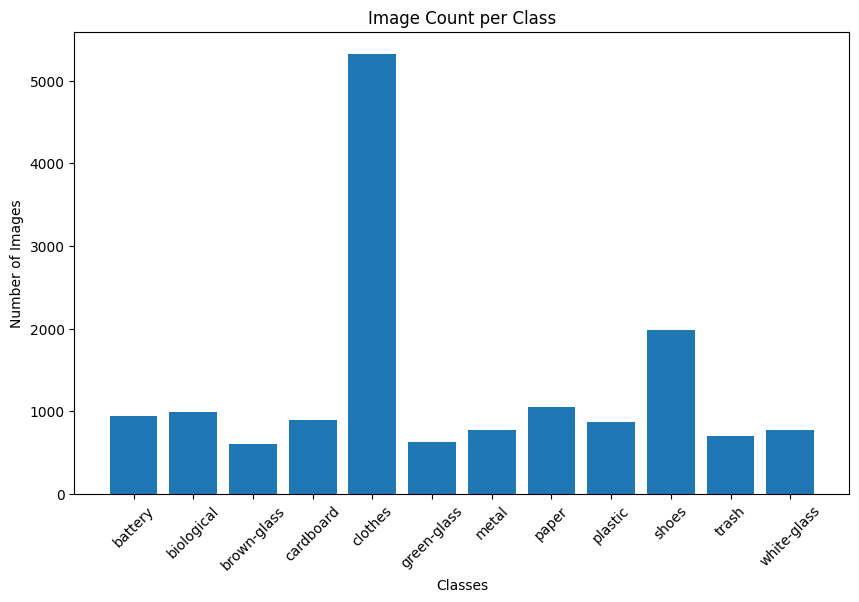

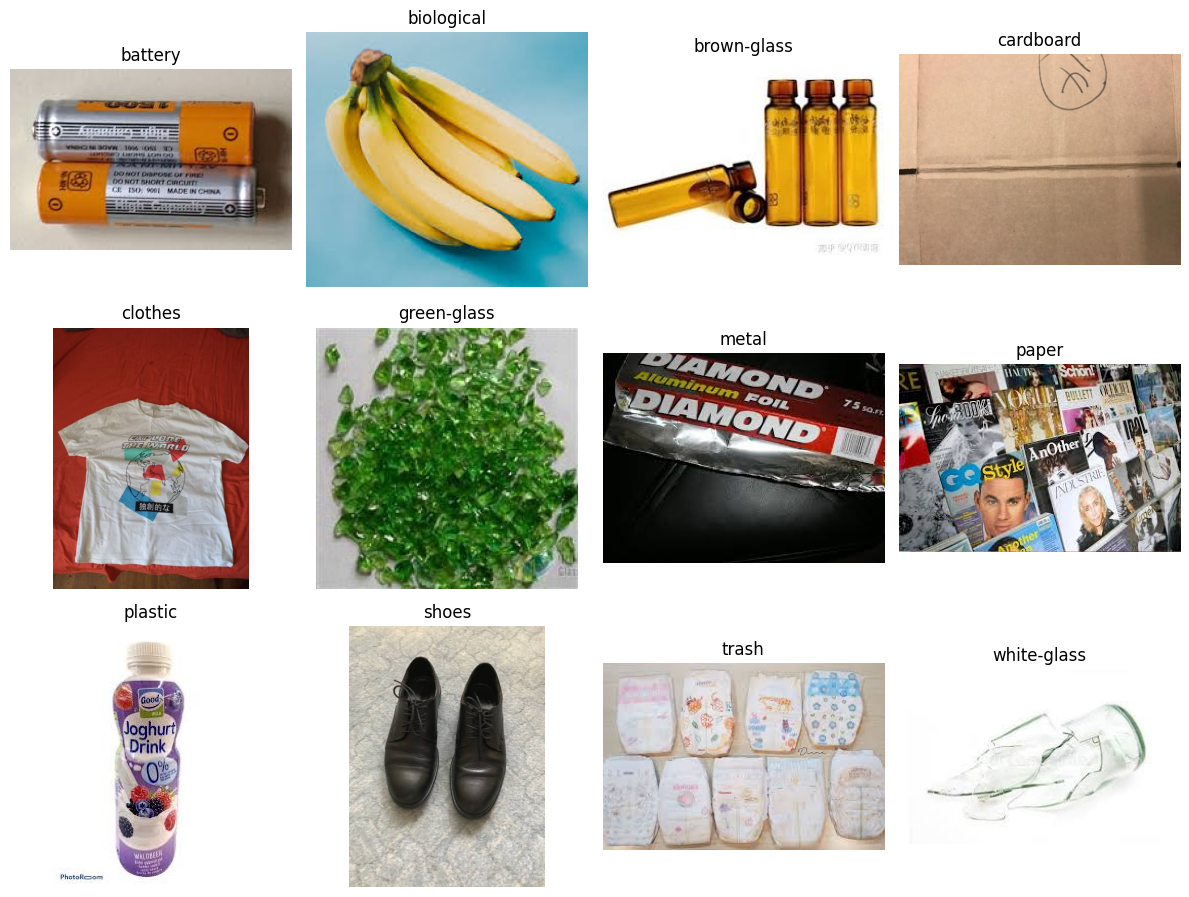

Data Inspection Phase completed in 2.05 seconds.


In [24]:
# Start timer for the data inspection phase
start_time = time.time()

# Update this path to point to where your dataset is stored
dataset_dir = 'garbage_classification'

# List all class directories
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
print("Found classes:", classes)

# Count images in each class
image_counts = {}
for cls in classes:
    images = glob(os.path.join(dataset_dir, cls, '*'))
    image_counts[cls] = len(images)
print("Image counts per class:", image_counts)

# Plot the number of images per class
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values())
plt.title("Image Count per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Display a sample image from each class
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
axes = axes.flatten()

for ax, cls in zip(axes, classes):
    # Taking the first image as a sample for each class
    image_path = glob(os.path.join(dataset_dir, cls, '*'))[0]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    ax.imshow(image)
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()

# End timer and print the duration for this phase
end_time = time.time()
print(f"Data Inspection Phase completed in {end_time - start_time:.2f} seconds.")

---


# Phase 1: Duplicate Removal (Deduplicaton)

This phase aims to remove duplicate images from our original dataset using perceptual hashing. The goal is to create a deduplicated dataset that will serve as the input for the subsequent quality filtering phase. 

**Key teps:**

- **Directory Setup:**  
  The original dataset is assumed to be organized by class in the `garbage_classification` folder. Duplicated images are copied (not moved) into a new folder called `deduplicated_dataset`, preserving the class structure.

- **Perceptual Hashing:**  
  Each image is processed using Pillow and `imagehash.average_hash` to compute a perceptual hash—a compact representation of the image's visual content. This hash is used to detect duplicates.

- **Duplicate Check:**  
  For each class folder, we maintain a set of accepted image hashes. If an image’s hash is not already in the set, it is copied to the deduplicated folder; otherwise, it is skipped (i.e., recognized as a duplicate).

- **Parallel Processing:**  
  The deduplication process is parallelized using `ThreadPoolExecutor` to speed up the computation over multiple images concurrently.

- **Time Tracking:**  
  The total time taken for this phase is measured using Python’s `time` module, helping us document the effi

**Summary:**
- This phase quickly scans through each class folder, calculates perceptual hashes for each image, and removes duplicates.
- It uses parallel processing to accelerate the deduplication process.
- Time tracking is incorporated to measure the efficiency of this step. preparation pipeline. Let me know if you need any further adjustments or additional details!

In [6]:
# Start timing Phase 1 (Duplicate Removal)
phase1_start = time.time()

# Directories for Phase 1
general_dir = "garbage_classification"  # Original dataset folder (with class subfolders)
dedup_dir = "deduplicated_dataset"       # Destination for deduplicated images

# Create deduplication output directory
os.makedirs(dedup_dir, exist_ok=True)

def dedup_process_image(file_path):
    """
    Compute a perceptual hash for the image using Pillow/imagehash.
    Returns the hash as a string.
    """
    try:
        pil_img = Image.open(file_path).convert('RGB')
        img_hash = str(imagehash.average_hash(pil_img))
        return img_hash
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_dedup_class_folder(class_name):
    src_class_path = os.path.join(general_dir, class_name)
    dedup_class_path = os.path.join(dedup_dir, class_name)
    os.makedirs(dedup_class_path, exist_ok=True)
    
    accepted_hashes = set()
    files = [os.path.join(src_class_path, f)
             for f in os.listdir(src_class_path)
             if f.lower().endswith(('.png','.jpg','.jpeg'))]
    
    # Process images using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(dedup_process_image, file): file for file in files}
        for future in as_completed(futures):
            file_path = futures[future]
            img_hash = future.result()
            if img_hash is None:
                continue
            # If not a duplicate, copy it to the deduplicated folder
            if img_hash not in accepted_hashes:
                accepted_hashes.add(img_hash)
                shutil.copy(file_path, os.path.join(dedup_class_path, os.path.basename(file_path)))
            # Else: duplicate found – skip copying
    
    return len(files)

# Process each class for deduplication
all_classes = [d for d in os.listdir(general_dir) if os.path.isdir(os.path.join(general_dir, d))]
for cls in all_classes:
    process_dedup_class_folder(cls)

phase1_end = time.time()
print(f"Phase 1 (Duplicate Removal) completed in {phase1_end - phase1_start:.2f} seconds.")

Phase 1 (Duplicate Removal) completed in 85.06 seconds.


---
# Phase 2: Quality Filtering & Logging
**Objective:**  
This phase refines the deduplicated dataset by filtering images based on quality metrics. Specifically, we evaluate each image on three key parameters:
- **Blurriness:** Measured using the variance of the Laplacian.
- **Brightness:** Measured as the mean pixel intensity.
- **Edge Density:** Measured using Canny edge detection to capture the amount of edge detail.

**Process:**
1. **Dimension Check:**  
   Images with dimensions below 100x100 pixels are rejected outright.

2. **Quality Metrics Calculation:**  
   Each image is converted to grayscale to compute:
   - **Blurriness Score:** Normalized by `BLUR_THRESHOLD`.
   - **Brightness Score:** Normalized by `BRIGHTNESS_THRESHOLD`.
   - **Edge Density Score:** Normalized by `EDGE_DENSITY_THRESHOLD` (set to 0.15 in this phase for higher selectivity).
   
   The three scores are summed to form a total quality score.

3. **Decision Logic:**  
   An image is accepted if its total score is at least `ACCEPTANCE_SCORE_THRESHOLD` (2.2). Otherwise, it is rejected. Accepted images are copied to the `final_filtered_dataset` folder, and rejected images to the `final_unseen_dataset` folder.

4. **Parallel Processing:**  
   We use `ThreadPoolExecutor` with 8 workers to process images concurrently for improved efficiency.

5. **Logging:**  
   For each class, a CSV file (e.g., `className_filtering_results.csv`) is generated to record:
   - File path
   - Blurriness, brightness, and edge density scores
   - Total quality score
   - Final decision and any rejection reason

6. **Summary Visualization:**  
   A bar chart is generated to compare the number of images in the final filtered versus unseen datasets for each class.

7. **Time Tracking:**  
   The phase duration is measured and printed at the end to help document processing efficiency.

**Usage:**  
Running this cell, after Phase 1 (Duplicate Removal), processes each class folder from the deduplicated dataset, applies the quality filters, logs results, and generates a summary graph.umentation, along with the code provided above, completes the final data preparation phase. Once you're satisfied with these results, we can move on to training your model. Let me know if you have any questions or need further modifications!

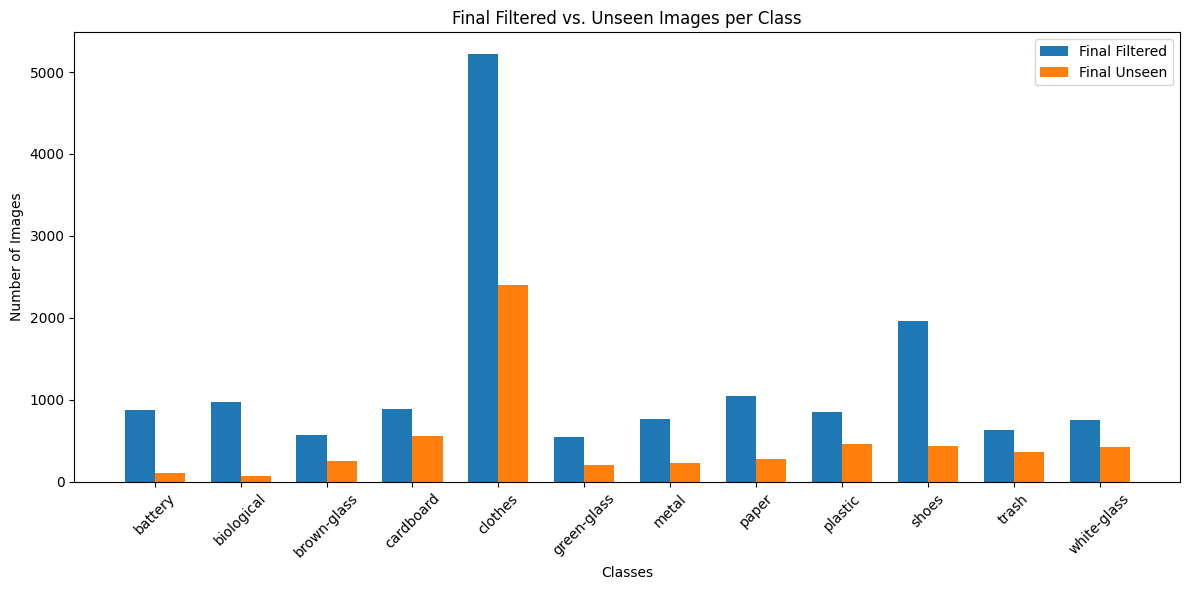

Phase 2 (Quality Filtering) completed in 48.72 seconds.


In [11]:
# Start timing Phase 2 (Quality Filtering)
phase2_start = time.time()

# Directories for Phase 2 (using deduplicated data from Phase 1)
source_dir = "deduplicated_dataset"  # Assume Phase 1 has been run and outputs deduplicated data
final_filtered_dir = "final_filtered_dataset"  # Destination for images passing quality filters
final_unseen_dir = "final_unseen_dataset"      # Destination for images failing quality filters
csv_log_suffix = "_filtering_results.csv"        # CSV log file suffix per class

# Create output directories if they don't exist
for base in [final_filtered_dir, final_unseen_dir]:
    os.makedirs(base, exist_ok=True)

# Quality thresholds and parameters (updated)
MIN_WIDTH, MIN_HEIGHT = 100, 100          # Minimum acceptable dimensions
BLUR_THRESHOLD = 100.0                    # Variance of Laplacian threshold for blurriness
BRIGHTNESS_THRESHOLD = 50                 # Minimum acceptable brightness
EDGE_DENSITY_THRESHOLD = 0.15             # New threshold for edge density (images with lower edge density get a lower normalized score)
ACCEPTANCE_SCORE_THRESHOLD = 2.2          # Total score must be >= this to be accepted

def compute_edge_density(image, low_threshold=50, high_threshold=150):
    """
    Compute edge density using Canny edge detection.
    Returns the density value.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    edge_pixels = np.sum(edges > 0)
    total_pixels = edges.shape[0] * edges.shape[1]
    density = edge_pixels / total_pixels
    return density

def process_image_quality(file_path):
    """
    Process an image for quality:
      - Check dimensions.
      - Compute normalized blurriness, brightness, and edge density scores.
    Returns a dictionary with file_path, metrics, total score, decision, and rejection reason.
    """
    image = cv2.imread(file_path)
    if image is None:
        return None
    h, w = image.shape[:2]
    if w < MIN_WIDTH or h < MIN_HEIGHT:
        return {
            "file_path": file_path,
            "blur_score": None,
            "brightness_score": None,
            "edge_density_score": None,
            "total_score": None,
            "decision": "rejected",
            "reason": "low dimensions"
        }
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Blurriness score (normalized)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    blur_score = min(variance / BLUR_THRESHOLD, 1.0)
    
    # Brightness score (normalized)
    brightness = np.mean(gray)
    brightness_score = min(brightness / BRIGHTNESS_THRESHOLD, 1.0)
    
    # Edge density score (normalized)
    density = compute_edge_density(image)
    edge_score = min(density / EDGE_DENSITY_THRESHOLD, 1.0)
    
    total_score = blur_score + brightness_score + edge_score
    decision = "accepted" if total_score >= ACCEPTANCE_SCORE_THRESHOLD else "rejected"
    reason = "" if decision == "accepted" else "low quality score"
    
    return {
        "file_path": file_path,
        "blur_score": blur_score,
        "brightness_score": brightness_score,
        "edge_density_score": edge_score,
        "total_score": total_score,
        "decision": decision,
        "reason": reason
    }

def process_quality_class_folder(class_name):
    src_class_path = os.path.join(source_dir, class_name)
    filtered_class_path = os.path.join(final_filtered_dir, class_name)
    unseen_class_path = os.path.join(final_unseen_dir, class_name)
    os.makedirs(filtered_class_path, exist_ok=True)
    os.makedirs(unseen_class_path, exist_ok=True)
    
    files = [os.path.join(src_class_path, f)
             for f in os.listdir(src_class_path)
             if f.lower().endswith(('.png','.jpg','.jpeg'))]
    
    results = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_image_quality, file): file for file in files}
        for future in as_completed(futures):
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
            except Exception as e:
                print(f"Error processing {futures[future]}: {e}")
    
    results = sorted(results, key=lambda x: x["file_path"])
    
    # Write results to a CSV log for this class
    csv_file = os.path.join(final_filtered_dir, class_name + csv_log_suffix)
    with open(csv_file, mode="w", newline="") as f:
        fieldnames = ["file_path", "blur_score", "brightness_score", "edge_density_score", "total_score", "decision", "reason"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for res in results:
            writer.writerow(res)
    
    # Copy files based on decision (do not incorporate duplicate filtering from Phase 1)
    for res in results:
        file_path = res["file_path"]
        base_name = os.path.basename(file_path)
        if res["decision"] == "accepted":
            shutil.copy(file_path, os.path.join(filtered_class_path, base_name))
        else:
            shutil.copy(file_path, os.path.join(unseen_class_path, base_name))
    return len(results)

# Process each class in the deduplicated dataset
for cls in os.listdir(source_dir):
    if os.path.isdir(os.path.join(source_dir, cls)):
        process_quality_class_folder(cls)

def generate_quality_summary_graph():
    filtered_counts = {}
    unseen_counts = {}

    for class_name in os.listdir(final_filtered_dir):
        class_path = os.path.join(final_filtered_dir, class_name)
        if os.path.isdir(class_path):
            filtered_counts[class_name] = len([f for f in os.listdir(class_path)
                                                if f.lower().endswith(('.png','.jpg','.jpeg'))])
    for class_name in os.listdir(final_unseen_dir):
        class_path = os.path.join(final_unseen_dir, class_name)
        if os.path.isdir(class_path):
            unseen_counts[class_name] = len([f for f in os.listdir(class_path)
                                              if f.lower().endswith(('.png','.jpg','.jpeg'))])
    all_classes = sorted(set(filtered_counts.keys()).union(set(unseen_counts.keys())))
    filtered_values = [filtered_counts.get(cls, 0) for cls in all_classes]
    unseen_values = [unseen_counts.get(cls, 0) for cls in all_classes]

    x = np.arange(len(all_classes))
    width = 0.35
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, filtered_values, width, label='Final Filtered')
    plt.bar(x + width/2, unseen_values, width, label='Final Unseen')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Final Filtered vs. Unseen Images per Class")
    plt.xticks(x, all_classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

generate_quality_summary_graph()

phase2_end = time.time()
print(f"Phase 2 (Quality Filtering) completed in {phase2_end - phase2_start:.2f} seconds.")

---
# Data Splitting Phase Documentation
This code splits the final filtered dataset into training, validation, and test sets while preserving the class structure. Time tracking is included to record how long this phase takes.

### Overview
- **Source Directory:**  
  The source directory (`final_filtered_dataset`) contains the final filtered images organized by class.

- **Target Structure:**  
  The code creates a new directory structure (`split_dataset`) with subdirectories for training, validation, and test sets. Each set retains the original class subdirectories.

- **Splitting Strategy:**  
  For each class:
  - 80% of the images are allocated for training/validation.
  - The remaining 20% are set aside for testing.
  - From the training/validation split, 12.5% is further split as the validation set (approximately 10% overall).

- **File Copying:**  
  The images are copied (using `shutil.copy2`) so that the original dataset remains intact.

- **Time Tracking:**  
  The phase's start and end times are recorded using the `time` module, and the total duration is printed.


### Key Points
- **Preserves Class Structure:**  
  Each class from the source is maintained in separate folders in the train, validation, and test splits.

- **Splitting Ratios:**  
  The overall split is approximately 80% training, 10% validation, and 10% testing.

- **Time Efficiency:**  
  The total time taken for the data splitting phase is tracked and printed, which aids in performance evaluation and documentation.

This documentation provides a clear explanation of the data splitting process, including how images are divided into different sets and how the directory structure is preserved. Let me know if you need further adjustments or additional details!

In [17]:
# Start time for data splitting
split_start = time.time()

# Directories (update paths as needed)
source_dir = "final_filtered_dataset"   # Your final filtered images (organized by class)
target_base_dir = "split_dataset"         # Base directory for split data

train_dir = os.path.join(target_base_dir, "train")
val_dir = os.path.join(target_base_dir, "val")
test_dir = os.path.join(target_base_dir, "test")

# Create target directories if they don't exist
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# List class subdirectories in the source directory
classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

for cls in classes:
    src_cls_dir = os.path.join(source_dir, cls)
    
    # Get list of image filenames for the class
    images = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Split: 80% train, 10% val, 10% test
    train_val_files, test_files = train_test_split(images, test_size=0.2, random_state=42)
    train_files, val_files = train_test_split(train_val_files, test_size=0.125, random_state=42)
    
    # Create class directories in each split folder and copy files
    for split, file_list in zip([train_dir, val_dir, test_dir],
                                  [train_files, val_files, test_files]):
        split_cls_dir = os.path.join(split, cls)
        os.makedirs(split_cls_dir, exist_ok=True)
        for fname in file_list:
            src_path = os.path.join(src_cls_dir, fname)
            dst_path = os.path.join(split_cls_dir, fname)
            shutil.copy2(src_path, dst_path)
    
    print(f"Class '{cls}': Total={len(images)} | Train={len(train_files)} | Val={len(val_files)} | Test={len(test_files)}")

split_end = time.time()
print(f"Data splitting complete. Time taken: {split_end - split_start:.2f} seconds.")

Class 'battery': Total=877 | Train=613 | Val=88 | Test=176
Class 'biological': Total=976 | Train=682 | Val=98 | Test=196
Class 'brown-glass': Total=566 | Train=395 | Val=57 | Test=114
Class 'cardboard': Total=882 | Train=616 | Val=89 | Test=177
Class 'clothes': Total=5223 | Train=3655 | Val=523 | Test=1045
Class 'green-glass': Total=549 | Train=384 | Val=55 | Test=110
Class 'metal': Total=762 | Train=532 | Val=77 | Test=153
Class 'paper': Total=1041 | Train=728 | Val=104 | Test=209
Class 'plastic': Total=851 | Train=595 | Val=85 | Test=171
Class 'shoes': Total=1958 | Train=1370 | Val=196 | Test=392
Class 'trash': Total=630 | Train=441 | Val=63 | Test=126
Class 'white-glass': Total=759 | Train=531 | Val=76 | Test=152
Data splitting complete. Time taken: 14.39 seconds.


---
# Data Generator Preparation and Class Weight Calculation
This cell sets up the Keras data generators for training, validation, and testing based on the split dataset. It also computes class weights to help mitigate class imbalance during training. Time tracking is included to measure how long this preparation phase takes.

### Key Steps:

- **Parameter Definitions:**  
  The image dimensions (224×224) and batch size (32) are defined for consistent preprocessing.

- **Directory Setup:**  
  The cell uses the training, validation, and test directories (created during the splitting phase) to load the images.

- **Data Augmentation:**  
  - For training, `ImageDataGenerator` is configured with rescaling and a suite of augmentations (rotation, shifts, shear, zoom, and horizontal flip) to provide additional variability.
  - For validation and testing, only rescaling is applied, ensuring that the evaluation is consistent.

- **Data Generators Creation:**  
  The generators automatically read images from the directory structure, assign labels based on folder names, and provide batches of augmented (or rescaled) images.

- **Class Weight Calculation:**  
  - The training generator’s class labels are extracted and used to compute balanced class weights.
  - These weights can later be passed to the model during training to emphasize underrepresented classes.

- **Visualization:**  
  A bar chart displays the distribution of training images across classes, allowing us to visually assess balance in the dataset.

- **Time Tracking:**  
  The time taken to set up the data generators and compute class weights is printed for documentation purposes.

This cell ensures that our data is well-prepared for training, with appropriate augmentation, balanced batch sampling, and class weighting to handle any imbalances. With this setup complete, we are ready to proceed to model training. Let me know if you need any further adjustments or explanations!

Found 10542 images belonging to 12 classes.
Found 1511 images belonging to 12 classes.
Found 3021 images belonging to 12 classes.
Class Weights: {0: 1.433115823817292, 1: 1.2881231671554252, 2: 2.2240506329113923, 3: 1.4261363636363635, 4: 0.24035567715458275, 5: 2.2877604166666665, 6: 1.6513157894736843, 7: 1.2067307692307692, 8: 1.4764705882352942, 9: 0.6412408759124087, 10: 1.992063492063492, 11: 1.6544256120527308}


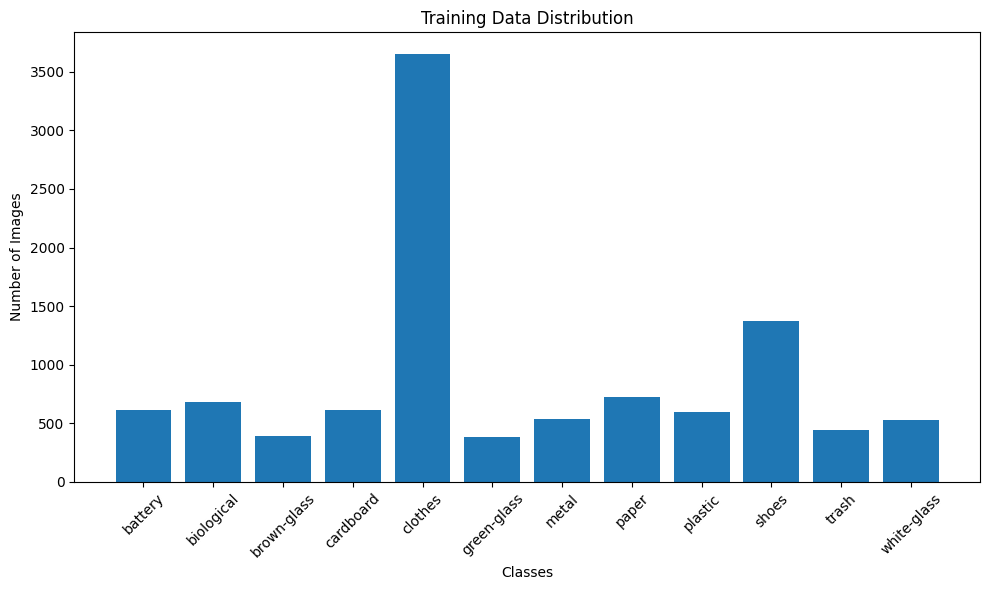

Data generators and class weights are ready. Time taken: 1.38 seconds.


In [19]:
# Start time for generator preparation
prep_start = time.time()

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Directories from the splitting phase
train_dir = "split_dataset/train"
val_dir = "split_dataset/val"
test_dir = "split_dataset/test"

# Data augmentation for training; only rescaling for validation and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights based on the training set labels
y_train = train_generator.classes  # Array of class labels
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
class_weights_dict = {int(label): weight for label, weight in zip(class_labels, class_weights)}

print("Class Weights:", class_weights_dict)

# Visualize the training data distribution
unique, counts = np.unique(y_train, return_counts=True)
train_distribution = dict(zip(unique, counts))
# Map indices back to class names using the generator's class_indices
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
train_distribution_named = {idx_to_class[k]: v for k, v in train_distribution.items()}

plt.figure(figsize=(10, 6))
plt.bar(train_distribution_named.keys(), train_distribution_named.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Training Data Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

prep_end = time.time()
print(f"Data generators and class weights are ready. Time taken: {prep_end - prep_start:.2f} seconds.")


---
# MobileNetV2 Model Training & Fine-Tuning
This section outlines the training process for our waste classification model using MobileNetV2. The training is divided into two phases:

1. **Initial Training (20 Epochs with Frozen Base):**  
   - **Objective:** Quickly train the newly added classification layers while keeping the pre-trained base fixed.  
   - **Setup:** We load MobileNetV2 with ImageNet weights (excluding the top layers) and freeze the entire base. Custom layers (global average pooling, dropout, and a 128-unit dense layer) are added, followed by a softmax output layer for 12 classes.  
   - **Compilation:** The model is compiled with the Adam optimizer (learning rate 1e-4), categorical crossentropy loss, and accuracy as the metric.  
   - **Callbacks:**  
     - **ReduceLROnPlateau:** Monitors validation loss and reduces the learning rate by a factor of 0.1 if no improvement is observed for 3 epochs, down to a minimum of 1e-7.  
     - **EarlyStopping:** Monitors validation loss and stops training if it doesn't improve for 5 epochs, restoring the best weights.
   - **Time Tracking:** The duration of the initial training phase is measured and printed.

2. **Fine-Tuning (10 Epochs with Unfrozen Last 20 Layers):**  
   - **Objective:** Fine-tune the model by unfreezing the last 20 layers of MobileNetV2 to allow the pre-trained features to adapt to our specific dataset.  
   - **Setup:** After unfreezing the layers, the model is recompiled with a lower learning rate (1e-5) to ensure gentle updates.  
   - **Time Tracking:** The time taken for the fine-tuning phase is measured and printed.

3. **Evaluation & Saving:**  
   - After training, the model is evaluated on the test set to obtain the final loss and accuracy.  
   - The final model is saved to disk as `final_mobilenet_model.h5` for future use or deployment.

This code, along with the detailed explanations above, documents our training approach clearly. It ensures efficient training through transfer learning, careful fine-tuning, and the use of callbacks to prevent overfitting—all while tracking the time taken for each phase.

In [21]:
# Define constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
num_classes = 12  # Define number of classes

# Assume that train_generator, val_generator, test_generator are already defined from data preparation.

# -------------------------------
# Build MobileNetV2-based Model
# -------------------------------
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False  # Freeze the base initially

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# -------------------------------
# Compile Model (Initial Training)
# -------------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks: ReduceLROnPlateau and EarlyStopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

# -------------------------------
# Initial Training: 20 Epochs
# -------------------------------
print("Starting initial training with frozen base...")
start_initial = time.time()
history_initial = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)
end_initial = time.time()
print(f"Initial training phase completed in {end_initial - start_initial:.2f} seconds.")

# -------------------------------
# Fine-Tuning: Unfreeze Last 20 Layers, Train 10 Epochs
# -------------------------------
print("Starting fine-tuning phase...")
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_finetune = time.time()
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)
end_finetune = time.time()
print(f"Fine-tuning phase completed in {end_finetune - start_finetune:.2f} seconds.")

# -------------------------------
# Evaluate on Test Set
# -------------------------------
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Optionally, save the final model
model.save("final_mobilenet_model.h5")

Starting initial training with frozen base...
Epoch 1/20
330/330 [==============================] - 377s 1s/step - loss: 1.3984 - accuracy: 0.5765 - val_loss: 0.6598 - val_accuracy: 0.8074 - lr: 1.0000e-04
Epoch 2/20
330/330 [==============================] - 336s 1s/step - loss: 0.6977 - accuracy: 0.7833 - val_loss: 0.4418 - val_accuracy: 0.8610 - lr: 1.0000e-04
Epoch 3/20
330/330 [==============================] - 266s 805ms/step - loss: 0.5508 - accuracy: 0.8286 - val_loss: 0.3578 - val_accuracy: 0.8855 - lr: 1.0000e-04
Epoch 4/20
330/330 [==============================] - 366s 1s/step - loss: 0.4799 - accuracy: 0.8496 - val_loss: 0.3242 - val_accuracy: 0.9007 - lr: 1.0000e-04
Epoch 5/20
330/330 [==============================] - 299s 905ms/step - loss: 0.4346 - accuracy: 0.8651 - val_loss: 0.2971 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 6/20
330/330 [==============================] - 252s 763ms/step - loss: 0.4007 - accuracy: 0.8700 - val_loss: 0.2755 - val_accuracy: 0.9113 - 

---
# Model Evaluation on Unseen Data
This cell evaluates the performance of our two saved models—**Model_pro.h5** and **final_mobilenet_model.h5**—using a test generator created from our unseen dataset (organized by class). The goal is to compare the accuracy and overall performance of both models on new, unseen data.

### Key Steps:

1. **Data Loading:**  
   - The unseen data is loaded from the `final_unseen_dataset` directory using Keras’ `ImageDataGenerator` with only rescaling applied.
   - The images are resized to 224×224 pixels, and labels are automatically assigned based on the folder names.

2. **Model Loading:**  
   - Both models are loaded from their saved files using `load_model()`.
   - An index-to-class mapping is constructed from the test generator’s class indices to interpret the predictions.

3. **Prediction & Metrics Calculation:**  
   - Predictions for each model are obtained and converted from probabilities to class labels.
   - Overall accuracy, classification reports (with precision, recall, and F1-score), and confusion matrices are computed for both models.
  
4. **Visualization:**  
   - Confusion matrices for both models are plotted side by side using Seaborn’s heatmap for easy visual comparison of the errors across classes.

### Summary:
- **Accuracy & Classification Reports:**  
  The overall accuracy, along with precision, recall, and F1-score for each class, is printed for both models.
  
- **Confusion Matrices:**  
  Side-by-side confusion matrices provide a visual insight into which classes are commonly misclassified.
  
This evaluation phase gives us a clear picture of each model’s robustness and accuracy on unseen data, guiding our decision on which approach to adopt. 

Found 5794 images belonging to 12 classes.
182/182 [==============================] - 118s 642ms/step
Model_pro.h5 Accuracy: 91.59%
Classification Report for Model_pro.h5:
              precision    recall  f1-score   support

     battery       0.85      0.98      0.91       105
  biological       0.92      0.96      0.94        75
 brown-glass       0.89      0.84      0.87       251
   cardboard       0.91      0.96      0.94       562
     clothes       0.99      0.99      0.99      2397
 green-glass       0.88      0.90      0.89       204
       metal       0.67      0.85      0.75       233
       paper       0.89      0.67      0.77       275
     plastic       0.82      0.67      0.74       462
       shoes       0.93      0.98      0.95       437
       trash       0.94      0.96      0.95       368
 white-glass       0.77      0.81      0.79       425

    accuracy                           0.92      5794
   macro avg       0.87      0.88      0.87      5794
weighted avg    

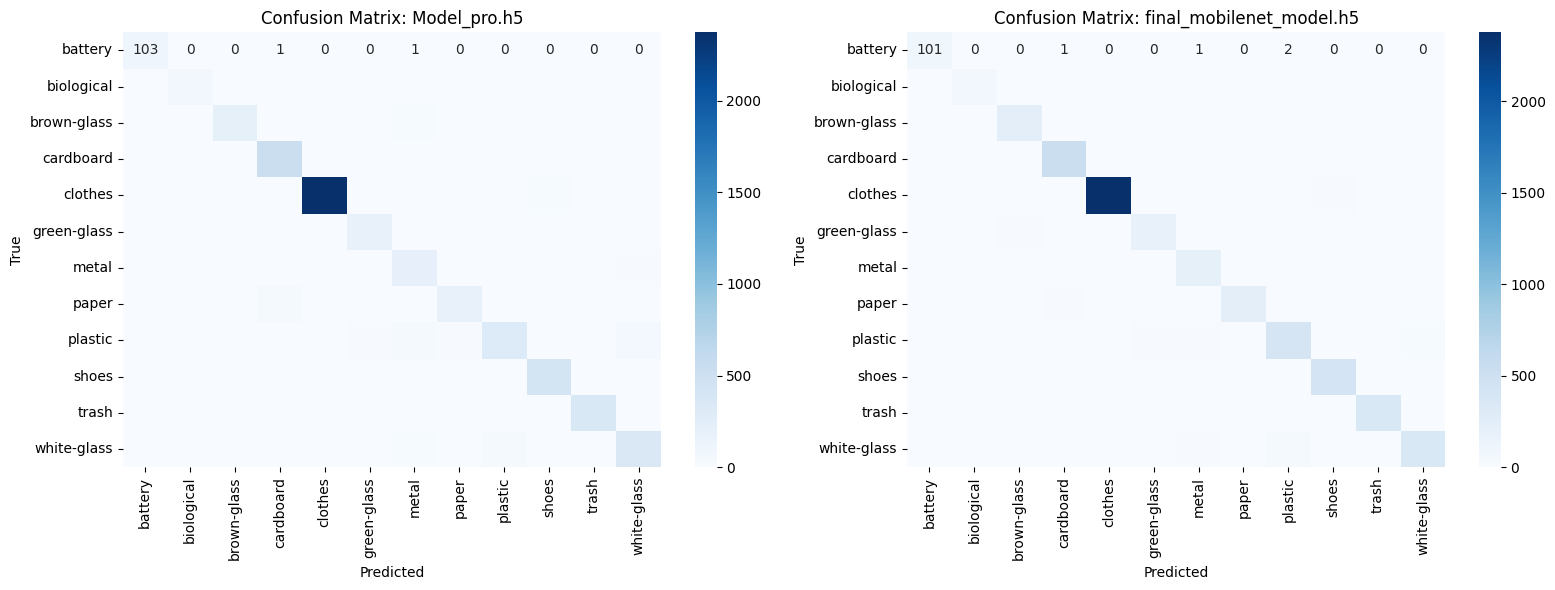

In [22]:
# Directories and parameters
UNSEEN_DIR = "final_unseen_dataset"  # Unseen dataset directory (organized by class)
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Create a test generator for the unseen dataset (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    UNSEEN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load both models
model_pro = load_model("Model_pro.h5")
model_mobilenet = load_model("final_mobilenet_model.h5")

# Define index-to-class mapping from the test generator
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Get true labels from the test generator
y_true = test_generator.classes

# Predict using Model_pro
predictions_pro = model_pro.predict(test_generator)
predicted_indices_pro = np.argmax(predictions_pro, axis=1)
y_pred_pro = [idx_to_class[i] for i in predicted_indices_pro]

# Predict using final_mobilenet
predictions_mobilenet = model_mobilenet.predict(test_generator)
predicted_indices_mobilenet = np.argmax(predictions_mobilenet, axis=1)
y_pred_mobilenet = [idx_to_class[i] for i in predicted_indices_mobilenet]

# Compute and print accuracy and classification report for Model_pro
accuracy_pro = accuracy_score(y_true, predicted_indices_pro)
print("Model_pro.h5 Accuracy: {:.2f}%".format(accuracy_pro * 100))
print("Classification Report for Model_pro.h5:")
print(classification_report(y_true, predicted_indices_pro, target_names=list(idx_to_class.values())))
cm_pro = confusion_matrix(y_true, predicted_indices_pro)
print("Confusion Matrix for Model_pro.h5:")
print(cm_pro)

# Compute and print accuracy and classification report for final_mobilenet
accuracy_mobilenet = accuracy_score(y_true, predicted_indices_mobilenet)
print("\nfinal_mobilenet_model.h5 Accuracy: {:.2f}%".format(accuracy_mobilenet * 100))
print("Classification Report for final_mobilenet_model.h5:")
print(classification_report(y_true, predicted_indices_mobilenet, target_names=list(idx_to_class.values())))
cm_mobilenet = confusion_matrix(y_true, predicted_indices_mobilenet)
print("Confusion Matrix for final_mobilenet_model.h5:")
print(cm_mobilenet)

# Optionally, plot the confusion matrices side by side
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm_pro, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values(), ax=axes[0])
axes[0].set_title("Confusion Matrix: Model_pro.h5")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values(), ax=axes[1])
axes[1].set_title("Confusion Matrix: final_mobilenet_model.h5")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
plt.tight_layout()
plt.show()